<a href="https://colab.research.google.com/github/Muskan2320/Deep-Learning/blob/main/Plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [ ]:
import tensorflow as tf

## GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    strategy = tf.distribute.OneDeviceStrategy(device = "/gpu:0")
    print("GPU found")
  except RuntimeError as e:
    print(e)
else:
  strategy = tf.distribute.get_strategy()
  print("Number of replicas: ", strategy.num_replicas_in_sync)

GPU found


## Data

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset

 99% 1.23G/1.25G [00:10<00:00, 132MB/s]
100% 1.25G/1.25G [00:11<00:00, 121MB/s]


In [ ]:
!unzip plant-disease-recognition-dataset.zip

Archive:  plant-disease-recognition-dataset.zip
  inflating: Test/Test/Healthy/8ddaa5a5caa5caa8.jpg  
  inflating: Test/Test/Healthy/8ddaac1bd6c8cd0a.jpg  
  inflating: Test/Test/Healthy/8ddd5ec1c0de38c4.jpg  
  inflating: Test/Test/Healthy/8def3f60308ab41b.jpg  
  inflating: Test/Test/Healthy/8def4d91382175c3.jpg  
  inflating: Test/Test/Healthy/8df452e2e38c0b6e.jpg  
  inflating: Test/Test/Healthy/8dfae9d78cc32089.jpg  
  inflating: Test/Test/Healthy/8e3dbccdfe08c850.jpg  
  inflating: Test/Test/Healthy/8e68163c62dc57d5.jpg  
  inflating: Test/Test/Healthy/8e6a823cce9ff40c.jpg  
  inflating: Test/Test/Healthy/8e77857194a59a87.jpg  
  inflating: Test/Test/Healthy/8e79802b3fb770c8.jpg  
  inflating: Test/Test/Healthy/8e7986d1ecd36445.jpg  
  inflating: Test/Test/Healthy/8e7e70a6878c1c79.jpg  
  inflating: Test/Test/Healthy/8e82b1a51bd11afe.jpg  
  inflating: Test/Test/Healthy/8e8470687be37378.jpg  
  inflating: Test/Test/Healthy/8e858c8397706b7b.jpg  
  inflating: Test/Test/Healthy/8e8

In [ ]:
train_dir = '/content/Train/Train'
test_dir = '/content/Test/Test'
valid_dir = '/content/Validation/Validation'

In [ ]:
directories = { train_dir: "Train", test_dir: "Test", valid_dir: "Validation"}

classes = ["Healthy", "Rust", "Powdery"]

print("---- Number of files available for each class in different directories ----\n")

for dir, name in directories.items():
  total = 0
  for c in classes:
    path = os.path.join(dir, c)
    num = len([f for f in os.listdir(path) if os.path.join(path, f)])
    total += num
    print(f'{name}:{c} -> {num}')
  print(f'Total {name}: {total}')
  print("-"*40)

---- Number of files available for each class in different directories ----

Train:Healthy -> 458
Train:Rust -> 434
Train:Powdery -> 430
Total Train: 1322
----------------------------------------
Test:Healthy -> 50
Test:Rust -> 50
Test:Powdery -> 50
Total Test: 150
----------------------------------------
Validation:Healthy -> 20
Validation:Rust -> 20
Validation:Powdery -> 20
Total Validation: 60
----------------------------------------


##Checking size of images

CNN require all the images feed into it to have fixed/equal square size like 128*128.

In [ ]:
from PIL import Image
from collections import defaultdict

In [ ]:
unique_dim = set()

for dir, name in directories.items():
  for c in classes:
    path = os.path.join(dir, c)

    for file in os.listdir(path):
      image = os.path.join(path, file)
      with Image.open(image) as img:
        unique_dim.add(img.size)

print(f'{len(unique_dim)} Unique dimesions are: {unique_dim}')

8 Unique dimesions are: {(4032, 3024), (4000, 2672), (4000, 3000), (5184, 3456), (2592, 1728), (3901, 2607), (4608, 3456), (2421, 2279)}


In [ ]:
# checking number of images of each dim

dim_count = defaultdict(int)                # a dictionary is created with values of keys as int. This int can replaced with list or any function
# dim_count["h"]                            Even though there is nothing in dict it don't give any error despite a zero value for undefined keys

for dir, name in directories.items():
  for c in classes:
    path = os.path.join(dir, c)

    for file in os.listdir(path):
      image = os.path.join(path, file)
      with Image.open(image) as img:
        dim_count[img.size] += 1

for dim, count in dim_count.items():
  print(f'{dim}: {count}')

(4000, 2672): 1130
(4000, 3000): 88
(4608, 3456): 72
(5184, 3456): 97
(2592, 1728): 127
(4032, 3024): 16
(2421, 2279): 1
(3901, 2607): 1


In [ ]:
# let's check if pixels of image are of same data type and vary from 0 to 255 so that no issue is encountered when scaling in range of 0 to 1

all_unit8 = True
all_pixel_in_range = True

for dir, name in directories.items():
  for c in classes:
    path = os.path.join(dir, c)

    for file in os.listdir(path):
      image = os.path.join(path, file)
      with Image.open(image) as img:
        img_arr = np.array(img)

      if img_arr.dtype != 'uint8':
        all_unit8 = False

      if img_arr.min() < 0 and img_arr.max() > 255:
        all_pixel_in_range = False

if all_unit8 == True:
  print("All images have same data type")
else:
  print("All images don't have same data type")

if all_pixel_in_range == True:
  print("All pixels in range")
else:
  print("All pixels not in range")

All images have same data type
All pixels in range


In [ ]:
# Let's see a few of images in our dataset
from concurrent.futures import ThreadPoolExecutor

def resize_img(paths):
  with ThreadPoolExecutor() as executor:
    img = list(executor.map(lambda x: Image.open(x).resize((350, 250)), paths))
    # executor.map() function executes the lambda function to all the images
    # executor executes the several task at the same time, task may not be executed in order but result are returned in order

  return img

def plot_img(paths, label):
  images = resize_img(paths)
  plt.figure(figsize =(10,10))
  for i in range(3):
    plt.subplot(1,3, i+1)
    plt.imshow(images[i])

  plt.title(label, x=-2, y=1)

In [ ]:
train_healthy = train_dir + '/Healthy'
train_rust = train_dir + '/Rust'
train_powder = train_dir + '/Powdery'

healthy_files = random.sample(os.listdir(train_healthy), 3)
rust_files = random.sample(os.listdir(train_rust), 3)
powder_files = random.sample(os.listdir(train_powder), 3)

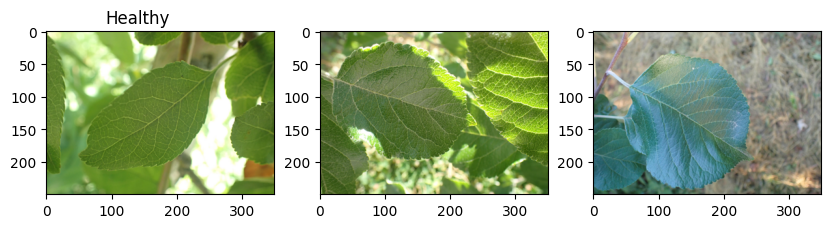

In [ ]:
healthy_paths = [os.path.join(train_healthy, f) for f in healthy_files]
plot_img(healthy_paths, "Healthy")

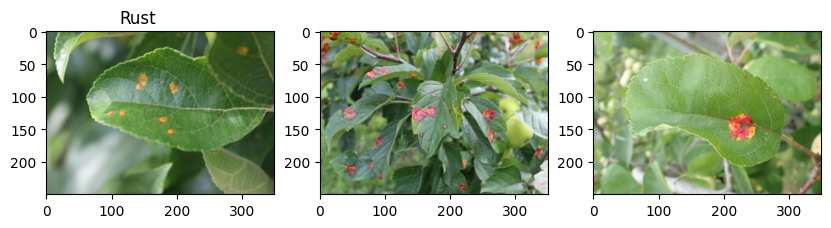

In [ ]:
rust_paths = [os.path.join(train_rust, f) for f in rust_files]
plot_img(rust_paths, "Rust")

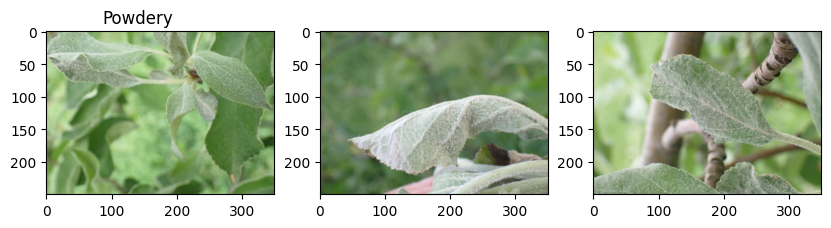

In [ ]:
powder_paths = [os.path.join(train_powder, f) for f in powder_files]
plot_img(powder_paths, "Powdery")

##Preprocessing

TensorFlow's "image_dataset_from_directory" help in pre-processing the images. Using this function we can split dataset in training and validation dataset, we can resize the images and further they can be manipulated for batching, shuffling, augmentating, and several other preprocessing steps.

In [ ]:
# Creating training dataset

train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = 123,
    validation_split = 0,
    crop_to_aspect_ratio = True                               # Resize images without aspect ratio distortion
)


# Creating testing dataset

test = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = 123,
    validation_split = 0,
    crop_to_aspect_ratio = True                               # Resize images without aspect ratio distortion
)


# Creating vallidation dataset

validation = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,
    image_size = (256, 256),
    shuffle = True,
    seed = 123,
    validation_split = 0,
    crop_to_aspect_ratio = True                               # Resize images without aspect ratio distortion
)

Found 1322 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


Next step of image pre-processing is to rescale the pixels from 0 to 255 to the range of 0 to 1.

In [ ]:
scaler = tf.keras.layers.Rescaling(1./255)

train = train.map(lambda x, y: (scaler(x), y))
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

##Data Augmentation

Keras has seven layers for data augmentation that include randomCrop, randomFlip, randomTranslation, randomBrightness, randomRotation, randomZoom, randomContrast.

In [ ]:
from keras.models import Sequential

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model

from keras.layers import Rescaling

from sklearn.pipeline import Pipeline

In [ ]:
# Let's apply randomBrightness, randomRotation, randomContrast

augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
            factor = (.25, .3),
            fill_mode = 'reflect',
            interpolation = 'bilinear',
            seed = 110
        ),

        tf.keras.layers.RandomBrightness(
            factor = (.45, .45),
            value_range = (0, 1.0),
            seed =110
        ),

        tf.keras.layers.RandomContrast(
            factor = (.5),
            seed = 110
        )
    ]
)

augmentation.build((None, 256, 256, 3))              # Augmentation pipline created
# Augmentation is done during training phase not during testing phase
# It means augmentation is called with fit() function but with predict()

##Convolutionary Neural Network

In [ ]:
with strategy.scope():               # Initiating model on GPU
  model = Sequential()               # Sequential model is the one where layers are stacks in sequence and executed in that order on;y

  model.add(augmentation)

  model.add(Conv2D(32,               # Number of filters/kernels
                   (3, 3),           # Size of kernel
                   strides = 1,
                   padding = 'same',
                   input_shape = (256, 245, 3)
  ))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (5,5), padding = 'same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3,3), padding = 'same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
  model.add(Dropout(0.3))

  model.add(Conv2D(256, (5,5), padding = 'same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
  model.add(Dropout(0.3))

  model.add(Conv2D(512, (3,3), padding = 'same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
  model.add(Dropout(0.3))

  model.add(Flatten())                            # Flattens input by reshaping it into a one-dimensional tensor

  # Fully connected layer
  model.add(Dense(2048))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  # Output Layer
  model.add(Dense(3, activation = 'softmax'))

In [ ]:
# Compiling model -> optimizer, loss, metrics
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001),
              loss = 'categorical_crossentropy',                # Ideal for multiclass classification over two classes
              metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 5,
                               mode = 'max',
                               restore_best_weights = True)

model_checkpoint = ModelCheckpoint('best_model.h5',
                                   monitor = 'val_accuracy',
                                   save_best_only = True)

In [ ]:
try:
  history = model.fit(train,
      epochs = 50,
      validation_data = test,
      callbacks = [early_stopping, model_checkpoint])
except Exception as e:
  print("An error occurred: ",e)

Epoch 1/50
83/83 [==============================] - 77s 805ms/step - loss: 4.8536 - accuracy: 0.6467 - val_loss: 7.0075 - val_accuracy: 0.3333
Epoch 2/50
83/83 [==============================] - 62s 674ms/step - loss: 1.9591 - accuracy: 0.7239 - val_loss: 8.0964 - val_accuracy: 0.3333
Epoch 3/50
83/83 [==============================] - 62s 691ms/step - loss: 1.3835 - accuracy: 0.7504 - val_loss: 8.8847 - val_accuracy: 0.3333
Epoch 4/50
83/83 [==============================] - 67s 744ms/step - loss: 1.0488 - accuracy: 0.7791 - val_loss: 5.1602 - val_accuracy: 0.5267
Epoch 5/50
83/83 [==============================] - 64s 722ms/step - loss: 0.9049 - accuracy: 0.8056 - val_loss: 3.4582 - val_accuracy: 0.5667
Epoch 6/50
83/83 [==============================] - 63s 700ms/step - loss: 0.6812 - accuracy: 0.8396 - val_loss: 1.5821 - val_accuracy: 0.6867
Epoch 7/50
83/83 [==============================] - 59s 660ms/step - loss: 0.5987 - accuracy: 0.8669 - val_loss: 1.6630 - val_accuracy: 0.6733

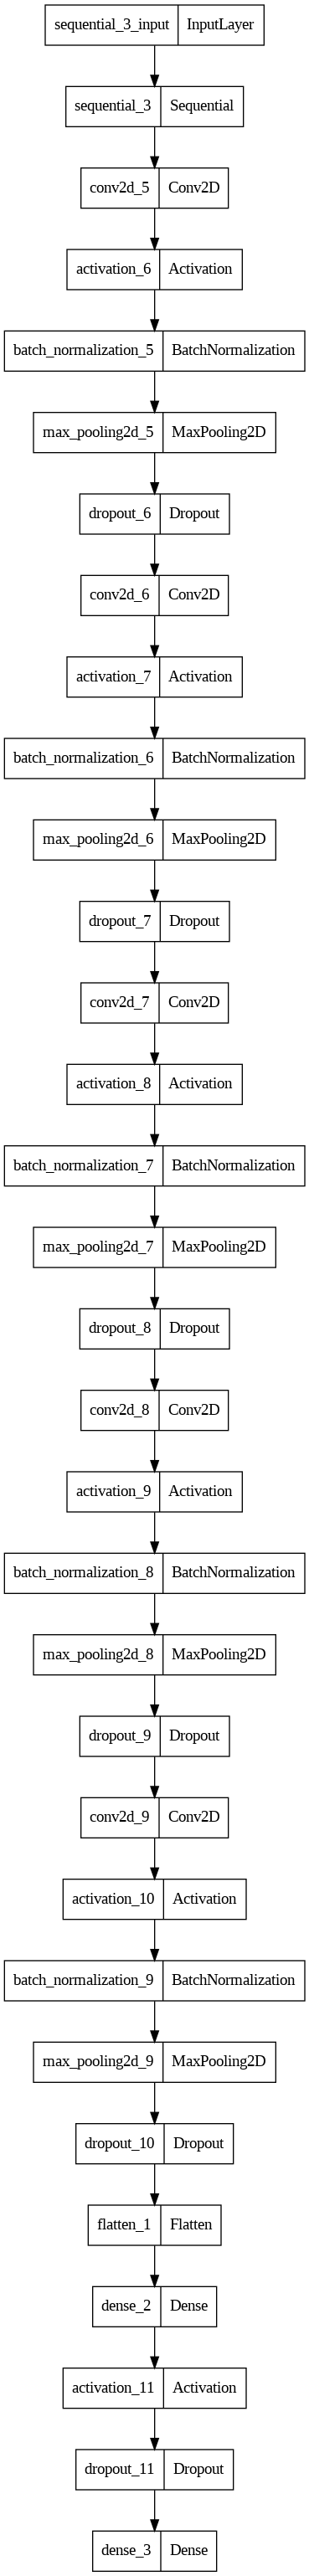

In [ ]:
tf.keras.utils.plot_model(model)

####Plotting results

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [ ]:
fig = make_subplots(rows = 1, cols = 2, subplot_titles=['<b>Loss over epochs</b>', '<b>Accuracy over epochs</b>'], horizontal_spacing = 0.2)

# Loss plot
train_loss = go.Scatter(x = list(range(len(history.history['loss']))),
                        y = history.history['loss'],
                        mode = 'lines',
                        line = dict(color = 'rgba(0, 67, 162,0.75)', width = 4),
                        name = 'Training',
                        showlegend = False)

val_loss = go.Scatter(x = list(range(len(history.history['val_loss']))), y = history.history['val_loss'],
                      mode = 'lines',
                      line = dict(color = 'rgba(255, 132, 0, 0.75)', width = 4),
                      name = 'Test',
                      showlegend = False)

fig.add_trace(train_loss, row = 1, col = 1)
fig.add_trace(val_loss, row = 1, col = 1)

# Accuracy plot
train_acc = go.Scatter(x = list(range(len(history.history['accuracy']))), y = history.history['accuracy'],
                       mode = 'lines',
                       line = dict(color = 'rgba(0, 67, 162, 0.75)', width = 4),
                       name = 'Training',
                       showlegend = True)

val_acc = go.Scatter(x = list(range(len(history.history['val_accuracy']))), y = history.history['val_accuracy'],
                     mode = 'lines',
                     line = dict(color = 'rgba(255, 132, 0, 0.75)', width = 4),
                     name = 'Test',
                     showlegend = True)

fig.add_trace(train_acc, row = 1, col = 2)
fig.add_trace(val_acc, row = 1, col = 2)

fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor='#EEF7EF',paper_bgcolor='#EEF6FF',
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

fig.show()

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_5 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128, 128, 32)     

##Performance Validation

In [ ]:
model.load_weights('best_model.h5')

pred = model.predict(validation)
val_loss, val_acc = model.evaluate(validation)

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc*100), '%')

4/4 [==============================] - 3s 27ms/step - loss: 1.3642 - accuracy: 0.7167

Validation Loss:  1.3642340898513794

Validation Accuracy:  72.0 %


Healthy Plant Image
1/1 [==============================] - 0s 245ms/step
Predicted Class:  Rust
Confidence Score:  0.99796474


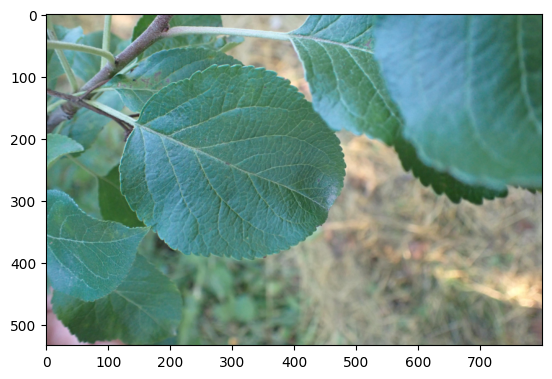

In [ ]:
from PIL import Image

image_path = '/content/Validation/Validation/Healthy/9bd4cc8c52e9d52a.jpg'
image = Image.open(image_path)
origW, origH = image.size

new_hig = int(origH * .2)
new_wei = int(origW * .2)

resized_image = image.resize((new_wei, new_hig))
print("Healthy Plant Image")
plt.imshow(resized_image)

processed_image = image.resize((256, 256))
processed_image = np.array(processed_image) / 255.0

pred = model.predict(np.expand_dims(processed_image, axis = 0))
labels = ['Healthy', 'Powdery', 'Rust']

pred_class = np.argmax(pred)

print('Predicted Class: ', labels[pred_class])
print('Confidence Score: ', pred[0][pred_class])

Powdery Plant
1/1 [==============================] - 0s 66ms/step
Predicted class:  Rust
Confidence Score:  0.99648523


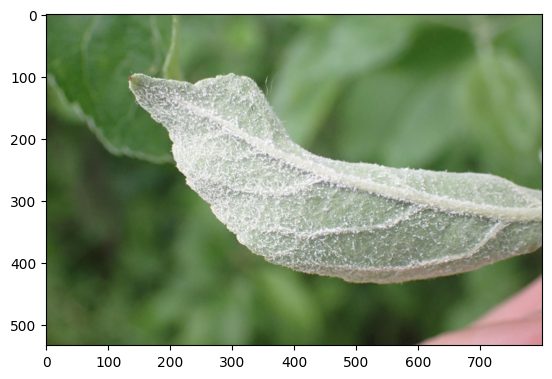

In [ ]:
image_path = '/content/Validation/Validation/Powdery/8fd27998ae52a4a6.jpg'
image = Image.open(image_path)
origW, origH = image.size

new_hig = int(origH * .2)
new_wei = int(origW * .2)

resized_image = image.resize((new_wei, new_hig))
print("Powdery Plant")
plt.imshow(resized_image)

processed_image = image.resize((256, 256))
processed_image = np.array(processed_image) / 255.0

pred = model.predict(np.expand_dims(processed_image, axis = 0))

pred_class = np.argmax(pred)

print("Predicted class: ", labels[pred_class])
print('Confidence Score: ', pred[0][pred_class])

Rusty Plant
1/1 [==============================] - 0s 79ms/step
Predicted Class:  Rust
Confidence score:  0.99648523


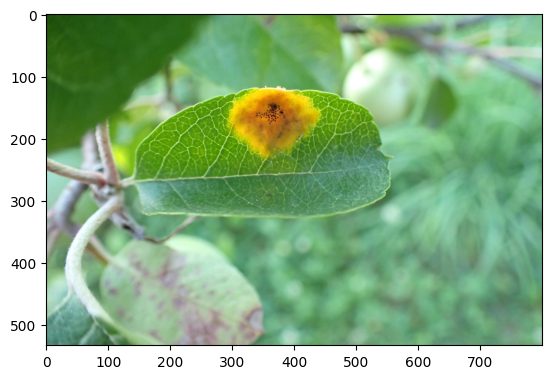

In [ ]:
image_path = '/content/Validation/Validation/Rust/860a8fbf3c6c00fd.jpg'
image = Image.open(image_path)
origW, origH = image.size

new_hig = int(origH * .2)
new_wei = int(origW * .2)

resized_image = image.resize((new_wei, new_hig))
print("Rusty Plant")
plt.imshow(resized_image)

processed_image = image.resize((256, 256))
processed_image = np.array(processed_image) / 255.0

pre = model.predict(np.expand_dims(processed_image, axis = 0))

pred_class = np.argmax(pred)

print("Predicted Class: ", labels[pred_class])
print('Confidence score: ', pred[0][pred_class])